In [9]:
import pandas as pd
import torch
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm
import cv2
import numpy as np
from torchvision import datasets, transforms

import torch.nn as nn
from torchvision import models
import torch.optim as optim
from torch.autograd import Variable


In [10]:
class ResNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet, self).__init__()
        self.model = models.resnet18(pretrained=False)

        # 鎖定 ResNet18 預訓練模型參數
        #for param in self.model.parameters():
        #    param.requires_grad = False

        # 修改輸出層輸出數量
        self.model.fc = nn.Linear(512, 2)
    def forward(self, x):
        logits = self.model(x)
        return logits

In [11]:

model=ResNet()
model.load_state_dict(torch.load("Resnet18_0809.pt"))
model.to("cuda")

c:\Users\HZT\miniconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\HZT\miniconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [12]:
transform2=transforms.Compose([
    transforms.Resize([224,224]), #缩放图片，保持长宽比不变，最短边的长为224像素,
    transforms.ToTensor(), #将图片转换为Tensor,归一化至[0,1]
    transforms.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5]) #标准化至[-1,1]
])

val_dir = "test"		
val_datasets = datasets.ImageFolder(val_dir, transform=transform2)
val_dataloader = torch.utils.data.DataLoader(val_datasets, batch_size=16, shuffle=False)


In [13]:

loss_list = []
accuracy_list = []

y_true=[]
y_pred=[]
loss_func = nn.CrossEntropyLoss()

model.eval()
eval_loss = 0.
eval_acc = 0.
for img, label in val_dataloader:
    img = Variable(img).cuda()
    label = Variable(label).cuda()
    out = model(img)
    loss = loss_func(out, label)
    eval_loss += loss.item()
    pred = torch.max(out, 1)[1]
    num_correct = (pred == label).sum()
    eval_acc += num_correct.item()

    y_true.extend(label.cpu().tolist())
    y_pred.extend(pred.cpu().tolist())
print('Test Loss: {:.6f}, Acc: {:.6f}'.format(eval_loss / (len(val_datasets)), eval_acc / (len(val_datasets))))

loss_list.append(eval_loss / (len(val_datasets)))
accuracy_list.append(100 * eval_acc / (len(val_datasets)))

Test Loss: 0.044871, Acc: 0.907000


In [14]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

In [15]:

tp=cm[0][0]
fn=cm[0][1]
fp=cm[1][0]
tn=cm[1][1]
print("Accuracy:",(tp+tn)/1000 )

p_presicion=tp/(tp+fp)
p_recall=tp/(tp+fn)
print('FIT precision:',p_presicion)
print('FIT recall:',p_recall)

n_presicion=tn/(tn+fn)
n_recall=tn/(fp+tn)
print('n_FIT precision:',n_presicion)
print('n_FIT recall:',n_recall)

print("F1",(2*p_presicion*p_recall)/(p_presicion+p_recall))

Accuracy: 0.907
FIT precision: 0.9266247379454927
FIT recall: 0.884
n_FIT precision: 0.8891013384321224
n_FIT recall: 0.93
F1 0.9048106448311157


[0.    0.116 1.   ] [0.   0.93 1.  ] [2 1 0]


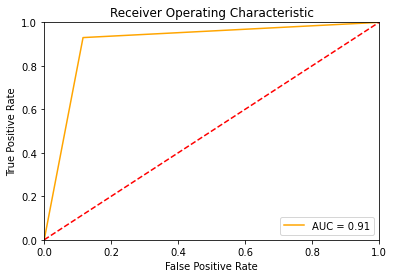

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
fpr, tpr, threshold = roc_curve(y_true, y_pred)
print(fpr, tpr, threshold)

auc1 = auc(fpr, tpr)
## Plot the result
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()    

In [17]:
auc1

0.907